In [1]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
# es 검색 테스트
es = Elasticsearch('http://localhost:9199')
body = {
    "query": {
        "bool": {
            "must": [
                {"multi_match": {
                    "type": "phrase_prefix",
                    "query": "경찰",
                    "fields": ["headLine", "content", "subHeadLine"]
                }},
                {"range":{
                    "date": {
                        "gte": "20221109",
                        "lte":"20221112"
                    }
                }}
            ]
        }
    }
}
res = es.count(index='kpf_bigkindslab_2022', body=body)
print(res['count'])

54


In [3]:
# 기간안의 모든 날짜 리스트 생성 def
def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [(start + timedelta(days=i)).strftime("%Y%m%d") for i in range((end-start).days+1)]
    return dates

In [4]:
stDt = '20180812'
edDt = '20180819'
keyword_list = ['이태원', '할로윈', '외국인'] # , ...

dates = date_range(stDt, edDt)

# es 검색 => 일별 기사건수 받아오기, 기사 없을 경우 0
# for문 사용해야함 수정필요, 임시작성
# es = Elasticsearch()
# body = {
#     "query": {
#         "bool": {
#             "must": [
#                 {"multi_match": {
#                     "type": "phrase_prefix",
#                     "query": keyword_list[0],
#                     "fields": ["headLine", "content", "subHeadLine"]
#                 }},
#                 {"range":{
#                     "date": {
#                         "gte": stDt,
#                         "lte":edDt
#                     }
#                 }}
#             ]
#         }
#     }
# }
# es.count(index='kpf_bigkindslab_*', body=body)

result = dict() # java 단으로 넘길 데이터
values = dict() # 통계 계산 사용 데이터
result['dates'] = dates

# 실제로는 es 검색 결과 기사건수 받아오는 것으로
for keyword in keyword_list: # 샘플데이터
    if keyword == '이태원':
        result[keyword] = [13,15,16,17,16,17,17,20]
        values[keyword] = [13,15,16,17,16,17,17,20]
    elif keyword == '할로윈':
        result[keyword] = [20,15,17,28,40,12,10,20]
        values[keyword] = [20,15,17,28,40,12,10,20]
    elif keyword == '외국인':
        result[keyword] = [65,21,61,21,12,32,15,35]
        values[keyword] = [65,21,61,21,12,32,15,35]

print(result)

{'dates': ['20180812', '20180813', '20180814', '20180815', '20180816', '20180817', '20180818', '20180819'], '이태원': [13, 15, 16, 17, 16, 17, 17, 20], '할로윈': [20, 15, 17, 28, 40, 12, 10, 20], '외국인': [65, 21, 61, 21, 12, 32, 15, 35]}


In [5]:
values_df = pd.DataFrame(values,index=result['dates'])
values_df

,이태원,할로윈,외국인
20180812,13,20,65
20180813,15,15,21
20180814,16,17,61
20180815,17,28,21
20180816,16,40,12
20180817,17,12,32
20180818,17,10,15
20180819,20,20,35


In [6]:
# 기초통계
def basic_statics(df):
    basic_res = []
    for key in keyword_list:
        val_dict = dict()
        val_dict['key'] = key
        val_dict['count'] = df.count()[key]
        val_dict['sum'] = df.sum()[key]
        val_dict['mean'] = df.mean()[key]
        val_dict['min'] = df.min()[key]
        val_dict['median'] = df.median()[key]
        val_dict['max'] = df.max()[key]
        val_dict['var'] = df.var()[key]
        val_dict['std'] = df.std()[key]
        basic_res.append(val_dict)
    return basic_res

basic_res = basic_statics(values_df)
print(basic_res) # java 단으로 넘길 기초통계 결과

[{'key': '이태원', 'count': 8, 'sum': 131, 'mean': 16.375, 'min': 13, 'median': 16.5, 'max': 20, 'var': 3.9821428571428568, 'std': 1.9955307206712847}, {'key': '할로윈', 'count': 8, 'sum': 162, 'mean': 20.25, 'min': 10, 'median': 18.5, 'max': 40, 'var': 94.5, 'std': 9.72111104761179}, {'key': '외국인', 'count': 8, 'sum': 262, 'mean': 32.75, 'min': 12, 'median': 26.5, 'max': 65, 'var': 409.35714285714283, 'std': 20.2325762782979}]


In [7]:
# 상관관계
def cor_statics(df):
    # print(df.corr(method='pearson'))
    # print(df.corr(method='pearson')['이태원'][1])
    for key1 in keyword_list:
        for key2 in keyword_list:
            pear_cor = stats.pearsonr(df[key1], df[key2])
            print(pear_cor[0]) # pearson 상관계수
            print(pear_cor[1]) # 유의확률
            z = np.polyfit(values_df[key1], values_df[key2], 1)
            f = np.poly1d(z)
            print(z[0], z[1]) # 기울기, 절편
        print('---')
cor_statics(values_df)

1.0
0.0
1.0000000000000004 -2.009718347115232e-14
-0.04234435114195801
0.9206991971671423
-0.206278026905831 23.627802690582982
-0.3759423867424321
0.3587081722972465
-3.8116591928251053 95.1659192825111
---
-0.04234435114195801
0.9206991971671423
-0.008692365835223106 16.551020408163264
1.0
0.0
1.0 2.51214793389404e-15
-0.2553055163808246
0.5416967086866459
-0.5313681027966736 43.510204081632644
---
-0.3759423867424321
0.3587081722972465
-0.037079043796894 17.58933868434828
-0.2553055163808246
0.5416967086866459
-0.12266620136101918 24.267318094573373
1.0
0.0
1.0000000000000004 0.0
---


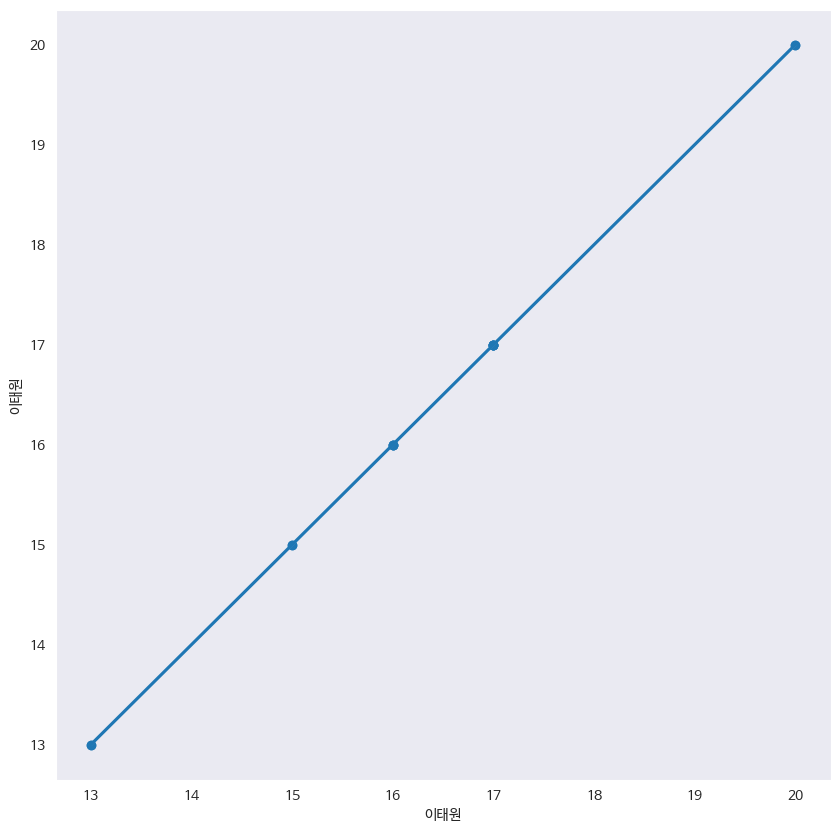

1.0000000000000004 -2.009718347115232e-14
0.9999999999999803


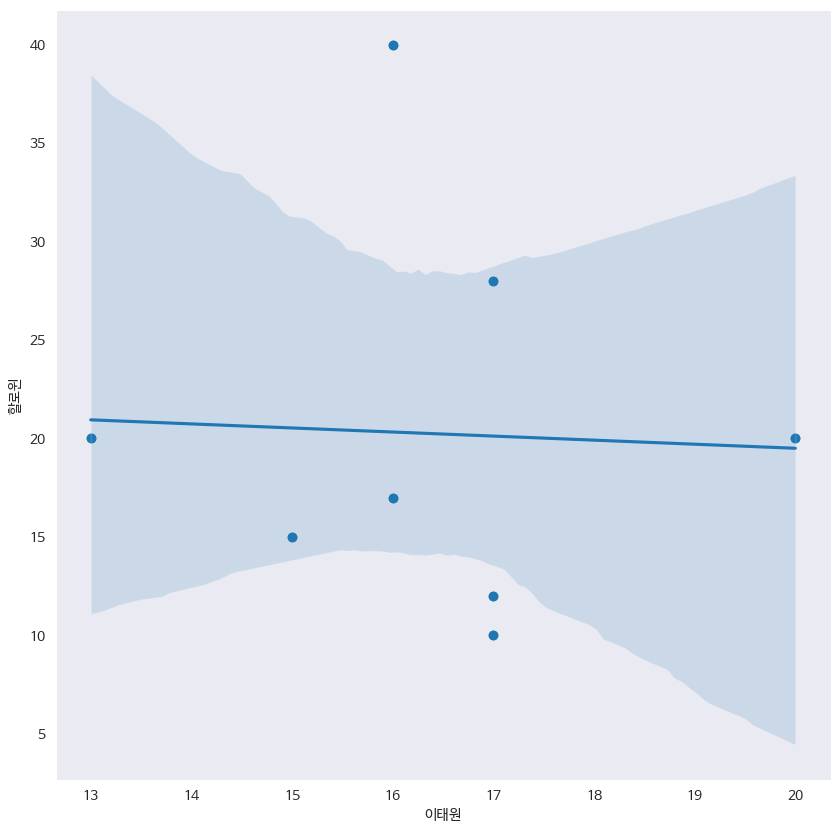

-0.206278026905831 23.627802690582982
23.42152466367715


D:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


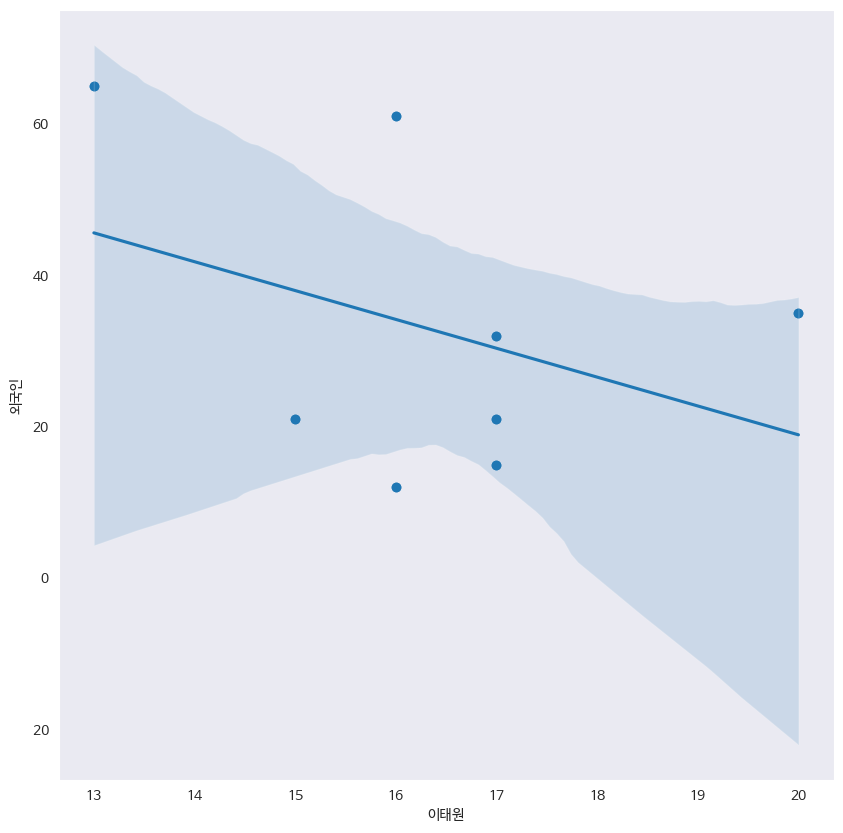

-3.8116591928251053 95.1659192825111
91.354260089686


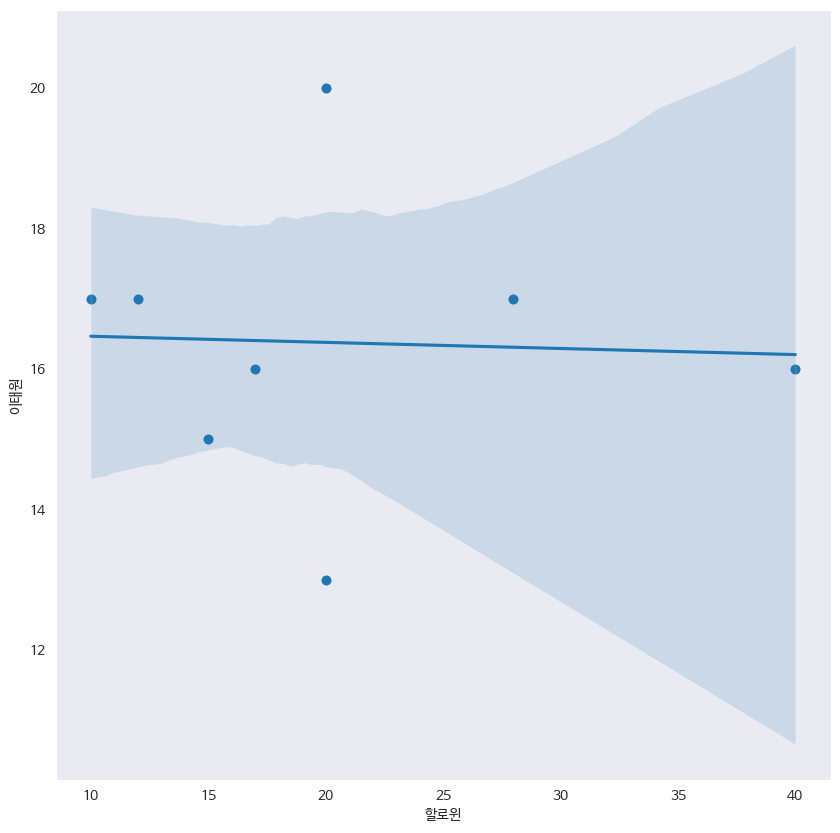

-0.008692365835223106 16.551020408163264
16.54232804232804


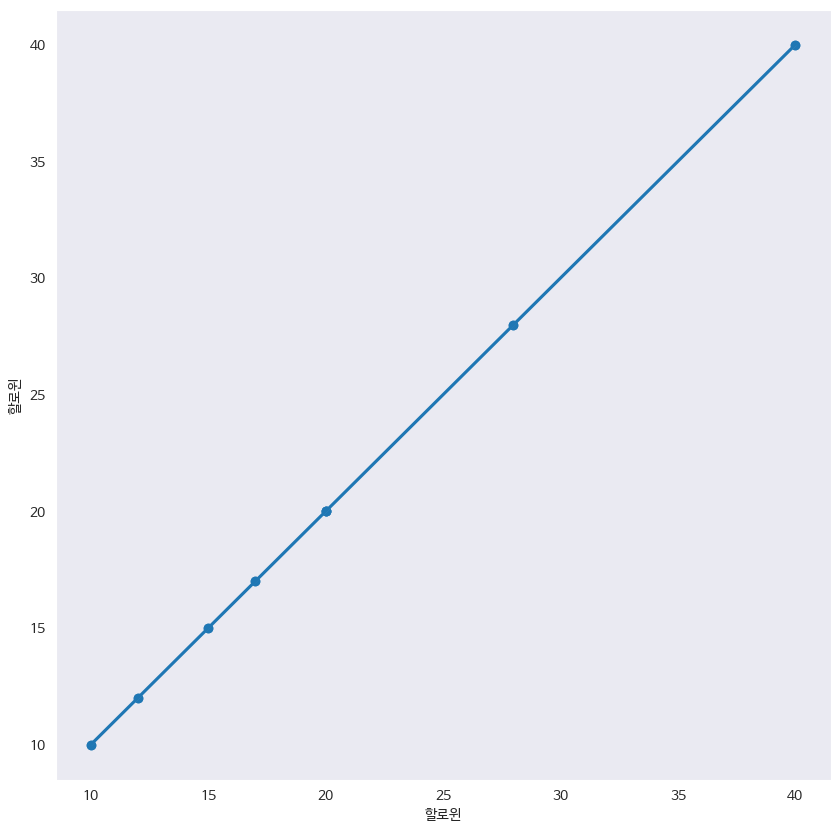

1.0 2.51214793389404e-15
1.0000000000000024


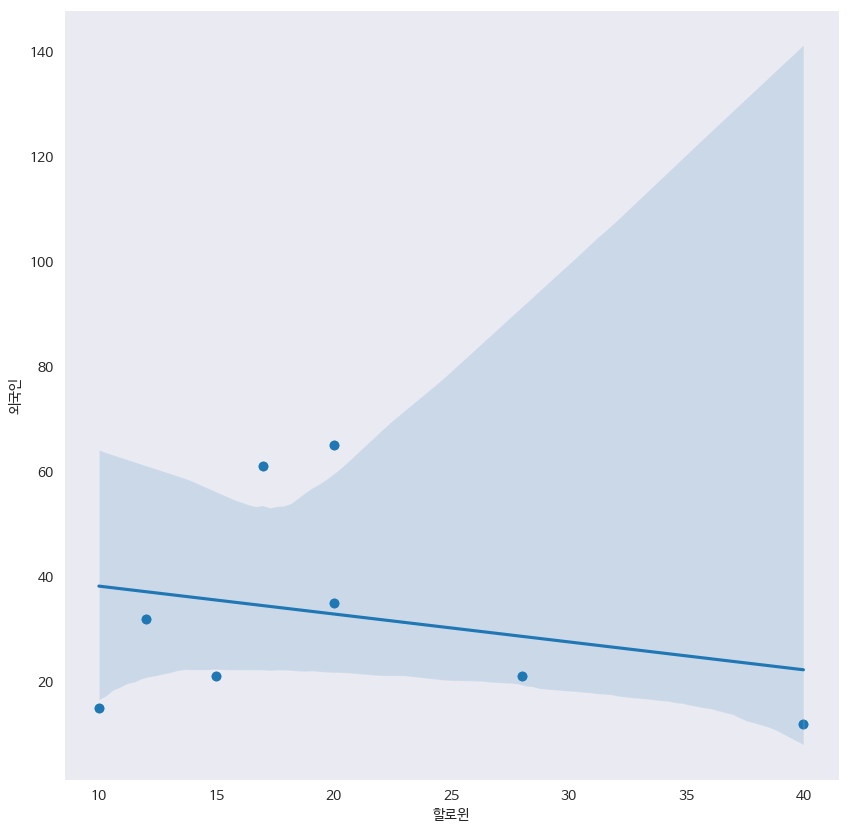

-0.5313681027966736 43.510204081632644
42.97883597883597


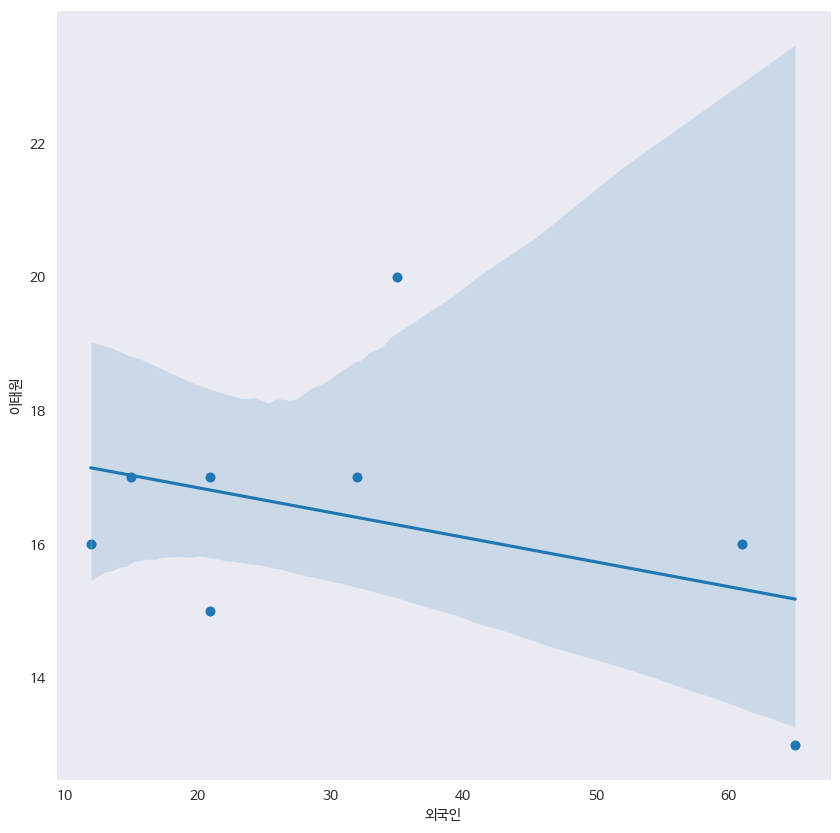

-0.037079043796894 17.58933868434828
17.552259640551387


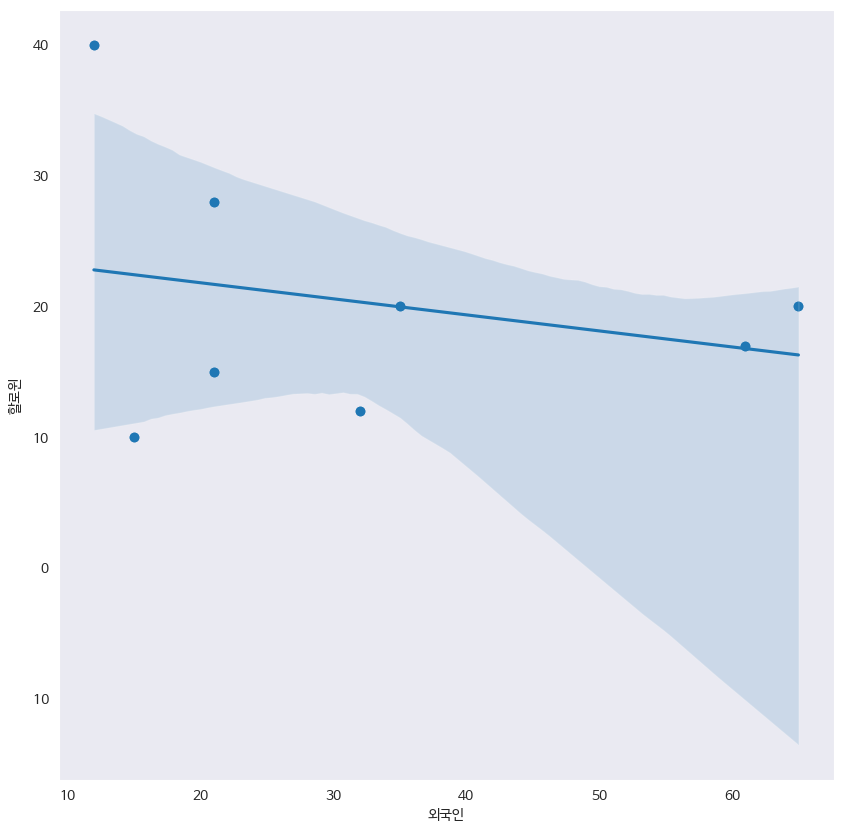

-0.12266620136101918 24.267318094573373
24.14465189321235


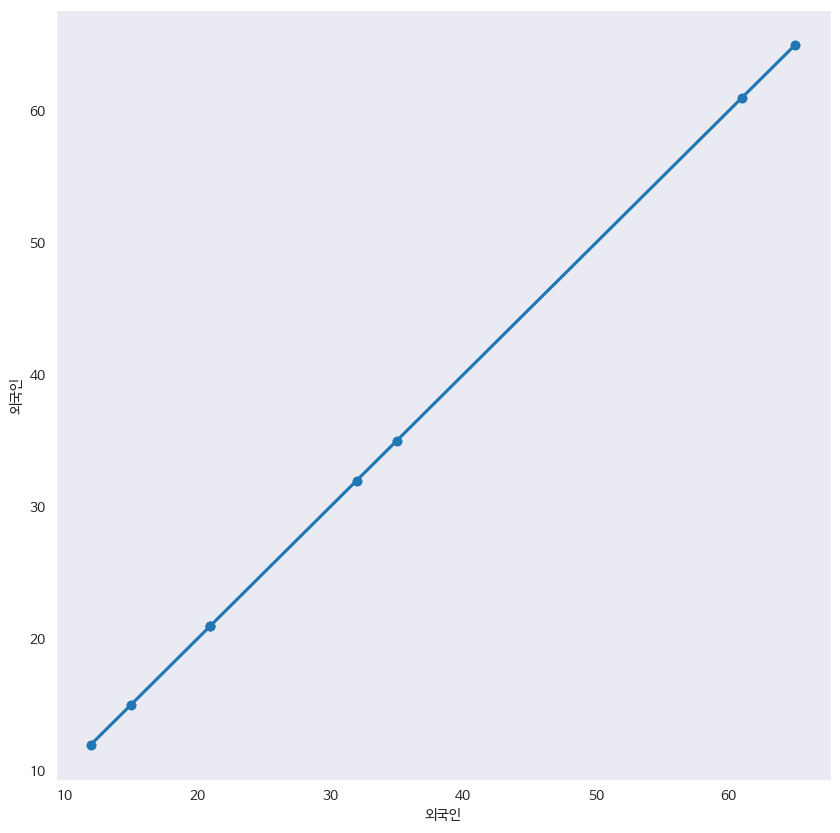

1.0000000000000004 0.0
1.0000000000000004


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# 한글폰트 사용 셋팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NanumBarunGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import seaborn as sns
# 산점도 작성
for key1 in keyword_list:
        for key2 in keyword_list:
            plt.figure(figsize=(10, 10))         # 플롯 사이즈 지정
            plt.scatter(values_df[key1], values_df[key2]) # 산점도
            sns.regplot(x=key1, y=key2, data=values_df)
            plt.xlabel(key1)                  # x축 레이블 지정
            plt.ylabel(key2)                   # y축 레이블 지정
            plt.grid()                           # 플롯에 격자 보이기
            plt.show()                           # 플롯 보이기
            z = np.polyfit(values_df[key1], values_df[key2], 1)
            f = np.poly1d(z)
            print(z[0], z[1]) # 기울기, 절편
            print(f(1)) #f(x)

In [9]:
from statsmodels.formula.api import ols
values_df.columns = ['A', 'B', 'C']
values_df
# ols('A ~ B + C',data=values_df).fit().summary()
# ols('B ~ A + C',data=values_df).fit().summary()
ols('C ~ A + B',data=values_df).fit().summary()
# print(val_sum)

D:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      C   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                 -0.099
Method:                 Least Squares   F-statistic:                    0.6848
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.546
Time:                        18:11:13   Log-Likelihood:                -33.907
No. Observations:                   8   AIC:                             73.81
Df Residuals:                       5   BIC:                             74.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    108.5278     69.022      1.572      0.177     -68.899     285.954
A             -3.9283      4.021     -0.977      0.373     -14.264       6.408
B             -0.5655      0.825     -0.685      0.524      -2.687       1.556
==============================================================================
Omnibus:                        1.970   Durbin-Watson:                   2.789
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                0.783
Skew:                           0.200   Prob(JB):                        0.676
Kurtosis:                       1.521   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""